In [1]:
"""
Created on Tue Oct 20 10:03:20 2020

@author: mariaalonso
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle


class DataLoader(object):
    """DataLoader class for screeening data"""
    def __init__(self, protease=None, substrate=None, plot_his=True, hist_density=False, z_threshold=None):
        
        # Make dictionary with all raw and zscored screening data
        self.raw = {}
        self.screens = {}
        self.substrates = {}
        self.proteases = {}
        keys = ['Bhatia1', 'Bhatia2', 'Bhatia3', 'GlympseBio1', 'GlympseBio2']
        files = ['Inputs/JesseScreen.csv', 'Inputs/JaideepScreen.csv', 
                 'Inputs/CarmenScreen.csv', 'Inputs/AndrewScreen_feb.csv', 
                 'Inputs/AndrewScreen_dec.csv']
        
        for i, element in enumerate(files):
            self.raw[keys[i]], self.substrates[keys[i]], self.proteases[keys[i]] = self.load(element, z_score = False)
            self.screens[keys[i]], _, _ = self.load(element, z_score = True)
        
        num_substrates = []
        num_proteases = []
        for key in self.substrates.keys():
            num_substrates.append(len(self.substrates[key]))
            num_proteases.append(len(self.proteases[key]))
            
        # Plot bargraph of number of substrates
        self.bar_graph(num_substrates, self.substrates.keys(), '# Peptides', '# Peptides/screen', 1) 
        self.bar_graph(num_proteases, self.proteases.keys(), '# Proteases', '# Proteases/screen', 2)
        
        # Look up protease or substrate
        if protease != None:
            top_id = self.lookup_protease(protease, z_threshold=z_threshold, plot_his=plot_his, den=hist_density)
            # f1 = open('outputs/lookup_'+protease+'.pkl', 'wb')
            # pickle.dump(self.temp_prot, f1)
            # f1.close()
            
            print('Best substrates for '+ protease+': '+ str(top_id))
            for el in top_id:
                cross_temp = self.lookup_substrate(el, z_threshold=z_threshold, plot_his=plot_his, den=hist_density)
                print('Cross-cutting of '+ el +' by: '+ str(cross_temp))
                # cross_cutting =  cross_cutting + cross_temp
            # cross_cutting = list(set(cross_cutting))
            # print('Cross-cutting by'+ protease+': '+ str(top_id))
                
            
        if substrate != None:
            top_id = self.lookup_substrate(substrate, z_threshold=z_threshold, plot_his=plot_his, den=hist_density)
            # f2 = open('outputs/lookup_'+substrate+'.pkl', 'wb')
            # pickle.dump(self.temp_subs, f2)
            # f2.close()
            
            print(substrate +' is best cleavaed by: '+ str(top_id))
            for el in top_id:
                cross_temp = self.lookup_protease(el, z_threshold=z_threshold, plot_his=plot_his, den=hist_density)
                # print('Other substrates well cleavaed by '+ el +': '+ str(cross_temp))
        
        
        
    def load(self, path, z_score=False):
        """load and zscore screeening data"""
        raw = pd.read_csv(path)
        data = raw.groupby('Substrate').mean().reset_index() # average duplicates
        substrates = list(data['Substrate'])
        proteases = list(data.iloc[:,1:].columns)
        proteases = [item.replace(' ', '') for item in proteases] #Correct for possible spaces
        data.columns = ['Substrate']+proteases  #Change names in df
        if z_score == True:
            data = data.set_index('Substrate')
            data = ((data - data.mean()) / data.std(ddof=0))
            # data = data.reset_index()
        return data, substrates, proteases

    def bar_graph(self, x_val, x_labels, y_label, title, num_fig):
        fig, ax = plt.subplots()
        x_len = np.arange(len(x_val))
        plt.bar(x_len, x_val)
        plt.xticks(x_len, (x_labels))
        plt.title(title)
        plt.ylabel(y_label)
        plt.show()
        fig.savefig('outputs/Fig'+str(num_fig)+'.png')
    
    def hist(self, val, x_label, y_label, title, identity, den):
        fig, ax = plt.subplots()
        n, bins, patches = plt.hist(val, density=den, alpha=0.75)
        plt.title(title+' '+identity)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.show()
        if den == False:
            fig.savefig('outputs/Fig_'+identity+'.png')
        else:
            fig.savefig('outputs/Fig_'+identity+'_normalized.png')
        
    def lookup_protease(self, protease, z_threshold=None, plot_his=True, den=False):
        self.temp_prot={} # build dictionary
        for key in self.proteases.keys(): 
            if protease in self.proteases[key]:
                print(protease+' in '+ key)
                self.temp_prot[key] = self.screens[key][protease]
        if plot_his == True:
            all_zscores = self.get_dict_vals(self.temp_prot)
            self.hist(all_zscores, 'z_scores', 'Frequency', 'Z-score distributions', protease, den)
        df_temp_prot1 = pd.DataFrame.from_dict(self.temp_prot) 
        df_temp_prot1.to_csv('outputs/'+protease+'_all_zscores.csv') # store dataframe option 1
        
        self.filtered = self.filter_z_score(self.temp_prot, z_threshold) # sort and filter data
        top_id = self.find_top_id(self.filtered)  #return id of top substrates 
        
        df_temp_prot2= pd.DataFrame() # build dataframe
        col = []
        for key in self.proteases.keys(): 
            if protease in self.proteases[key]:
                sorted_data = self.filtered[key]
                subs_temp = pd.DataFrame(list(sorted_data.index))
                z_scores_temp = pd.DataFrame(list(sorted_data.values)) 
                if subs_temp.empty == False:
                    col.append(key + ' Substrate')
                    col.append(key + ' Ranked Z-scores')
                    df_temp_prot2 = pd.concat([df_temp_prot2, subs_temp, z_scores_temp], ignore_index=True, axis=1)
                    df_temp_prot2.columns = col
        # display(df_temp_prot2)
        df_temp_prot2.to_csv('outputs/'+protease+'_zscores.csv')
        
        return top_id
        
    def lookup_substrate(self, substrate, z_threshold=None, plot_his=True, den=False):
        self.temp_subs={} # build dictionary
        for key in self.substrates.keys(): 
            if substrate in self.substrates[key]:
                print(substrate+' in '+ key)
                self.temp_subs[key] = self.screens[key].loc[substrate]  
        if plot_his == True:
            all_zscores = self.get_dict_vals(self.temp_subs)
            self.hist(all_zscores, 'z_scores', 'Frequency', 'Z-score distributions', substrate, den)
        df_temp_subs1 = pd.DataFrame.from_dict(self.temp_subs) 
        df_temp_subs1.to_csv('outputs/'+substrate+'_all_zscores.csv') # store dataframe option 1 
        
        self.filtered = self.filter_z_score(self.temp_subs, z_threshold) # sort and filter data
        top_id = self.find_top_id(self.filtered)  #return id of top proteases
        
        df_temp_subs2= pd.DataFrame() # build dataframe
        col = []
        for key in self.filtered.keys():  ## from substrates to fitlered
            if substrate in self.substrates[key]:
                sorted_data = self.filtered[key]
                prot_temp = pd.DataFrame(list(sorted_data.index))
                z_scores_temp = pd.DataFrame(list(sorted_data.values)) 
                if prot_temp.empty == False:
                    col.append(key + ' Protease')
                    col.append(key + ' Ranked Z-scores')
                    df_temp_subs2 = pd.concat([df_temp_subs2, prot_temp, z_scores_temp], ignore_index=True, axis=1)
                    df_temp_subs2.columns = col
        # display(df_temp_subs2)
        df_temp_subs2.to_csv('outputs/'+substrate+'_zscores.csv')
        
        return top_id
        
    def get_dict_vals(self, dictionary):
        vals = []
        for key in dictionary.keys(): 
            vals.append(dictionary[key].values)
        return vals
    
    def filter_z_score(self, data, z_threshold):
        filtered = {}
        for key in data.keys():
            val = data[key]
            if z_threshold != None:
                filtered[key] = val[val>z_threshold].sort_values(ascending = False)
            else:
                filtered[key] = val.sort_values(ascending = False)
        return filtered
    
    def find_top_id(self, data):
        top_id = list()
        for key in data.keys():
            top_id = top_id+list(data[key].index)
        top_id = set(top_id)  #find unique ids
        return list(top_id)

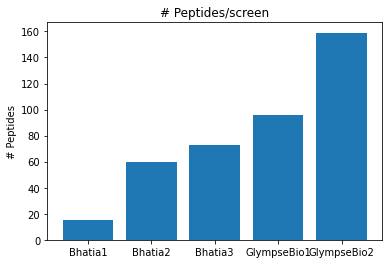

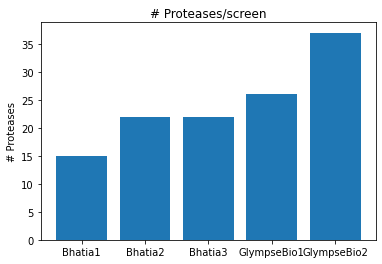

MMP13 in Bhatia1
MMP13 in Bhatia2
MMP13 in Bhatia3
MMP13 in GlympseBio1
MMP13 in GlympseBio2


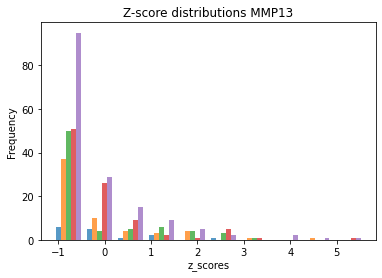

Best substrates for MMP13: ['PX03', 'PX06', 'Q1']
PX03 in Bhatia1
PX03 in GlympseBio1
PX03 in GlympseBio2


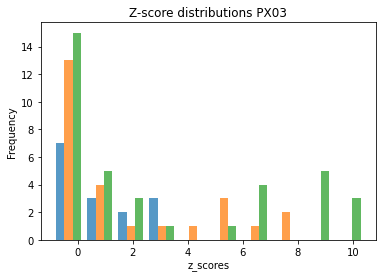

Cross-cutting of PX03 by: ['MMP7', 'FAP', 'MMP14', 'MMP8', 'MMP19', 'MMP15', 'MMP13', 'MMP12', 'MMP1', 'MMP9', 'MMP17', 'MMP3', 'MMP10', 'MMP2']
PX06 in GlympseBio1
PX06 in GlympseBio2


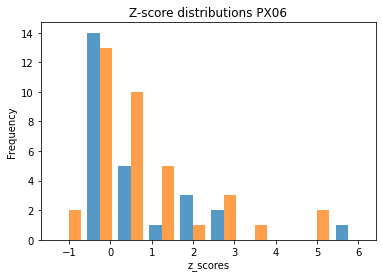

Cross-cutting of PX06 by: ['GZMA', 'MMP13']
Q1 in Bhatia1
Q1 in Bhatia2
Q1 in GlympseBio1
Q1 in GlympseBio2


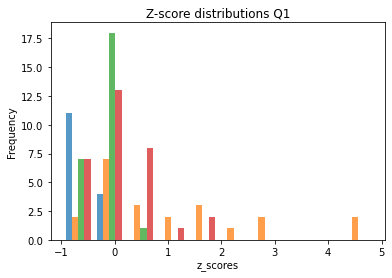

Cross-cutting of Q1 by: ['MMP13', 'MMP2']


In [2]:
data = DataLoader(protease = 'MMP13', z_threshold=4)

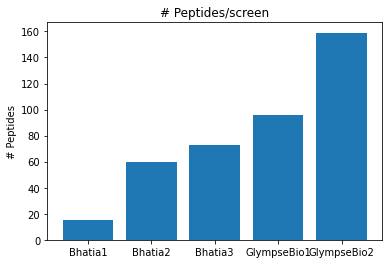

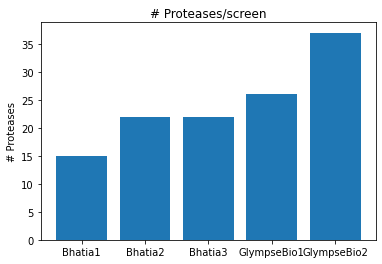

Q3 in Bhatia1
Q3 in Bhatia2
Q3 in GlympseBio1
Q3 in GlympseBio2


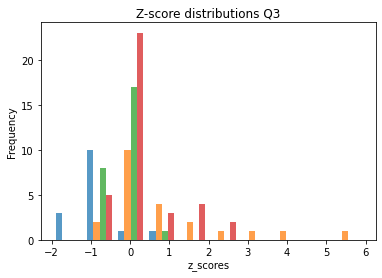

Q3 is best cleavaed by: ['CTSB', 'MMP9', 'MMP26', 'MMP13', 'MMP11']
CTSB in Bhatia2


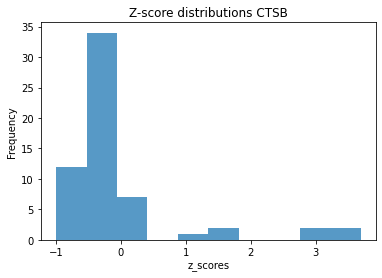

Other proteases that will cross-cut CTSB: ['Q3', 'Q9', 'Q1', 'Q10']
MMP9 in Bhatia2
MMP9 in GlympseBio1
MMP9 in GlympseBio2


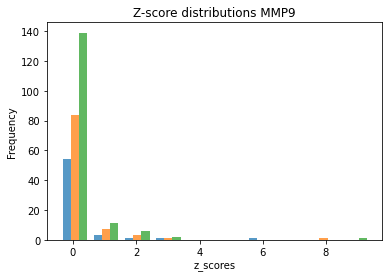

Other proteases that will cross-cut MMP9: ['Q6', 'PX02', 'Q3', 'PQ3', 'TQ51', 'Q1', 'PX03', 'PX06']
MMP26 in Bhatia2


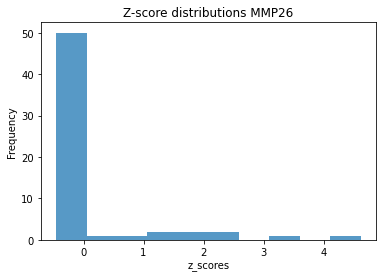

Other proteases that will cross-cut MMP26: ['PQ3', 'PQ16', 'Q3', 'PQ19']
MMP13 in Bhatia1
MMP13 in Bhatia2
MMP13 in Bhatia3
MMP13 in GlympseBio1
MMP13 in GlympseBio2


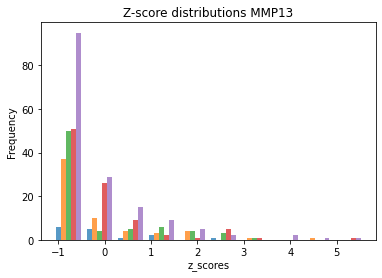

Other proteases that will cross-cut MMP13: ['TQ53', 'TQ55', 'LQ82', 'PQ17', 'PX12', 'PQ16', 'LQ86', 'PX22', 'PX06', 'FX18', 'LQ4', 'TQ51', 'Q3', 'LQ87', 'Q1', 'PQ19', 'LQ9', 'PX03', 'PX07']
MMP11 in Bhatia1
MMP11 in Bhatia2
MMP11 in GlympseBio2


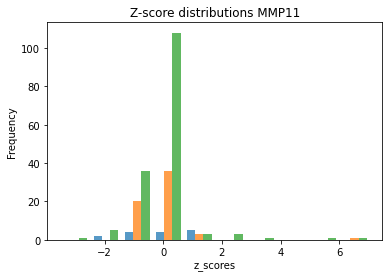

Other proteases that will cross-cut MMP11: ['Q8', 'Q3', 'PQ16', 'SQ10', 'SQ12']


In [72]:
data = DataLoader(substrate = 'Q3', z_threshold=2)

In [34]:
filtered = data.filtered
# print(filtered)
top_subs = list()
for key in data.filtered.keys():
    top_subs = top_subs+list(data.filtered[key].index)
    print(top_subs)



['PX03']
['PX03', 'Q1', 'Q3', 'PQ17', 'PQ16']
['PX03', 'Q1', 'Q3', 'PQ17', 'PQ16', 'LQ86', 'LQ87', 'LQ4', 'LQ9', 'LQ82']
['PX03', 'Q1', 'Q3', 'PQ17', 'PQ16', 'LQ86', 'LQ87', 'LQ4', 'LQ9', 'LQ82', 'PX03', 'PX12', 'PQ16', 'PX07', 'PX06', 'PX22', 'FX18']
['PX03', 'Q1', 'Q3', 'PQ17', 'PQ16', 'LQ86', 'LQ87', 'LQ4', 'LQ9', 'LQ82', 'PX03', 'PX12', 'PQ16', 'PX07', 'PX06', 'PX22', 'FX18', 'PX03', 'PX06', 'TQ51', 'TQ53', 'TQ55', 'PQ19']


In [ ]:
subs_temp = pd.DataFrame(data = list(data.screens['Bhatia1']['MMP13'].index))
z_scores_temp = pd.DataFrame(data = list(data.screens['Bhatia1']['MMP13'].values))
df = pd.concat([subs_temp, z_scores_temp], ignore_index=True, axis=1)
df

In [ ]:
data.temp_prot

In [ ]:
temp_prot = pd.DataFrame()
columns = []
sorted_data = data.screens['Bhatia1']['MMP13'].sort_values(ascending = False)
columns.append('Bhatia1 substrates')
subs_temp = pd.DataFrame(list(sorted_data.index))
display(subs_temp)
columns.append('Bhatia1 Ranked Z-scores')
z_scores_temp = pd.DataFrame(list(sorted_data.values)) 
display(z_scores_temp)
temp_prot = pd.concat([temp_prot, subs_temp, z_scores_temp], ignore_index=True, axis=1)
display(temp_prot)
temp_prot.columns =  columns
display(temp_prot)

In [ ]:
list(data.screens['Bhatia1']['MMP13'].index)

In [ ]:
data.screens['Bhatia1']['MMP13'].values

In [ ]:
data.temp_prot
df_temp_prot = pd.DataFrame.from_dict(data.temp_prot) 
df_temp_prot.to_csv('outputs/Fig_MMP13.csv')

In [ ]:


import datetime
import pandas as pd
import numpy as np

todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(10), periods=10, freq='D')

columns = ['A','B', 'C']
df_ = pd.DataFrame(columns=columns)
df_

In [ ]:
data.screens


In [ ]:
data = DataLoader(substrate = 'LQ87')
data.raw
data.screens
data.substrates
data.proteases
data.temp_prot